# Implementing an Adaptive Linear Neuron (Adaline) in Python

In this notebook, we will implement an **Adaptive Linear Neuron (Adaline)** using gradient descent. Adaline is a single-layer neural network that uses a linear activation function, and it was developed by Bernard Widrow and Ted Hoff.

Unlike the classical perceptron (which uses a hard threshold for its activation), Adaline uses a continuous linear activation. It trains by minimizing a **mean squared error** (MSE) cost function rather than the misclassification rate directly. When the weights converge under gradient descent, Adaline can learn linear decision boundaries for binary classification tasks.

We will apply Adaline on a subset of the **Iris dataset**, specifically using data from the Iris-setosa and Iris-versicolor classes. These data points can be separated by a linear boundary based on their sepal length and petal length.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import Image
import os

## The Iris dataset

The [Iris dataset](https://archive.ics.uci.edu/ml/datasets/Iris) is a very popular dataset in machine learning. It consists of 150 flower samples belonging to three different species of Iris (Iris-setosa, Iris-versicolor, Iris-virginica). For each flower, the following features are provided:

1. Sepal length (in cm)
2. Sepal width (in cm)
3. Petal length (in cm)
4. Petal width (in cm)

In this notebook, we'll focus only on **Iris-setosa** and **Iris-versicolor**, i.e., the first 100 entries (50 of each). We'll use:
- **Sepal length** (feature index 0)
- **Petal length** (feature index 2)

to build our classifier.

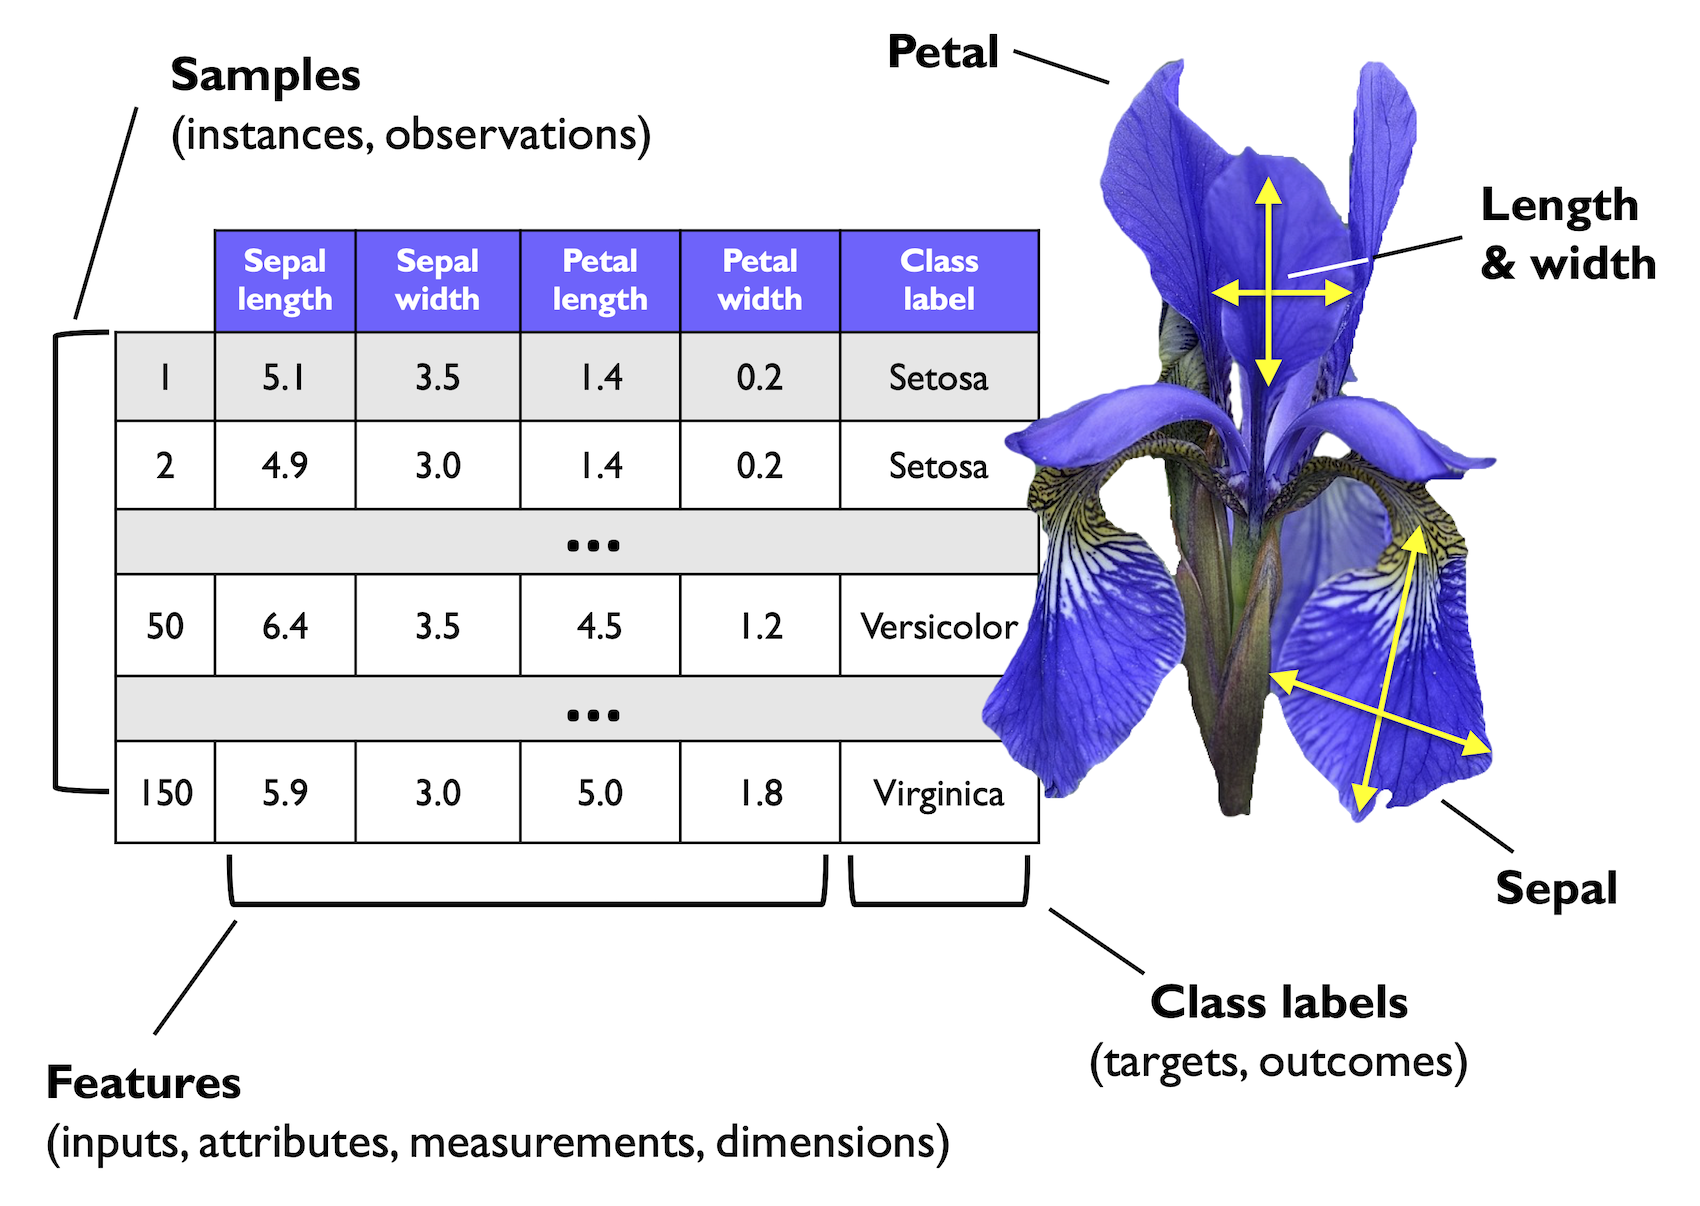

In [2]:
Image(filename='../tex/lecture4/Figures/01_08.png', width=500) 

In [3]:
# Reading-in the Iris data
# Note: If the URL is not accessible, the code will try to read the file 'iris.data' locally.

try:
    s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
    print('From URL:', s)
    df = pd.read_csv(s,
                     header=None,
                     encoding='utf-8')
except Exception:
    s = 'iris.data'
    print('From local Iris path:', s)
    df = pd.read_csv(s,
                     header=None,
                     encoding='utf-8')

df.tail()

From URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [4]:
df.shape

(150, 5)

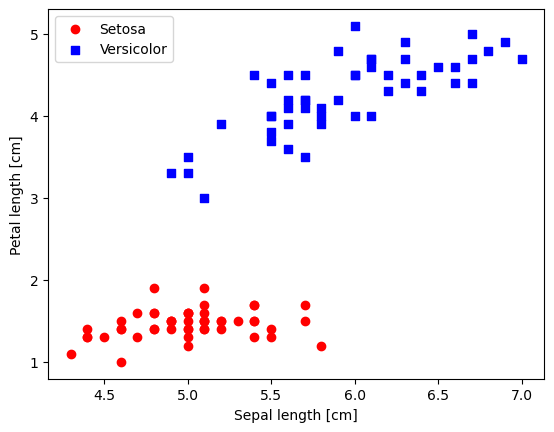

In [5]:
# Select only setosa and versicolor (first 100 rows)
y = df.iloc[0:100, 4].values
# Encode the class labels: Setosa=0, Versicolor=1
y = np.where(y == 'Iris-setosa', 0, 1)

# Extract sepal length (col 0) and petal length (col 2)
X = df.iloc[0:100, [0, 2]].values

# Plot the two classes
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='Setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='s', label='Versicolor')

plt.xlabel('Sepal length [cm]')
plt.ylabel('Petal length [cm]')
plt.legend(loc='upper left')
plt.show()

In [6]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [7]:
X.shape

(100, 2)

In [8]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
    """
    Plots the decision boundaries for a classifier.

    Parameters
    ----------
    X : array-like, shape = [n_examples, n_features]
        Feature matrix.
    y : array-like, shape = [n_examples]
        True class labels.
    classifier : object
        Trained classifier with a .predict() method.
    resolution : float (optional)
        Step size for the meshgrid.
    """
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    # Predict class labels for each point on the meshgrid
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)

    # Plot the decision surface (regions)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')

## Defining the Adaline algorithm

Below is the implementation of a simple Adaline classifier using **gradient descent**. Key points:

- We initialize the weights (including a bias term) to small random numbers.
- We compute the **net input** as \( z = X \cdot w + b \).  
- The **activation** function for Adaline is the identity function (i.e., output is just the net input).  
- We use **Mean Squared Error (MSE)** as the loss function.  
- Each epoch, we update the weights by computing the gradient of the MSE loss.

In [9]:
class AdalineGD:
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes (epochs) over the training dataset.
    random_state : int
      Random number generator seed for random weight initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : float
      Bias term after fitting.
    losses_ : list
      Mean squared error (MSE) loss values at each epoch.
    missed_ : list
      Number of misclassified labels at each epoch (based on a 0.5 threshold).
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
            Training vectors.
        y : array-like, shape = [n_examples]
            Target values (0 or 1 in our case).

        Returns
        -------
        self : object
        """
        rgen = np.random.RandomState(self.random_state)
        # Initialize weights and bias
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = 0.0

        self.losses_ = []
        self.missed_ = []

        for i in range(self.n_iter):
            # Net input
            net_input = self.net_input(X)
            # Adaline output is the linear activation (identity)
            output = self.activation(net_input)
            # Errors
            errors = (y - output)

            # Count how many misclassifications at this epoch
            # Using threshold 0.5: if activation >= 0.5 => class 1, else 0
            self.missed_.append(np.sum(np.abs(y - self.predict(X))))

            # Gradient update
            # Update each weight using the average gradient
            for j in range(self.w_.shape[0]):
                self.w_[j] += self.eta * (X[:, j] * errors).mean()
            self.b_ += self.eta * errors.mean()

            # Compute the Mean Squared Error (MSE)
            loss = (errors ** 2).mean()
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        """Calculate the net input z = Xw + b."""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Linear (identity) activation function for Adaline."""
        return X

    def predict(self, X):
        """Return class label after unit step at threshold 0.5"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)


## Training Adaline on the Iris dataset

We now train the Adaline classifier on the two-class Iris problem using the raw (unscaled) features. Keep in mind that if the learning rate is too large, the algorithm might not converge, and if it's too small, the algorithm will converge slowly.

In [10]:
eta = 0.01
ada = AdalineGD(n_iter=15, eta=eta)

In [11]:
ada.fit(X, y)

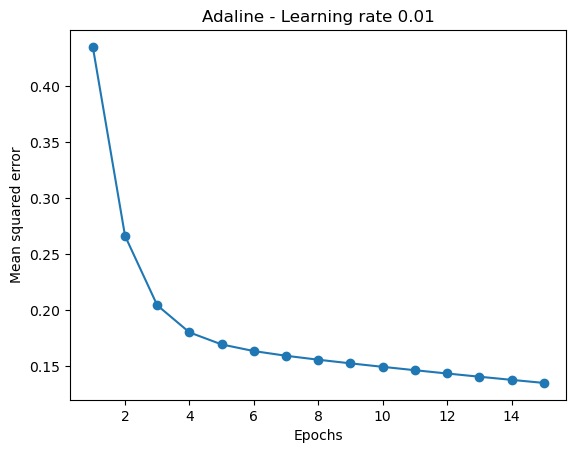

In [12]:
plt.plot(range(1, len(ada.losses_) + 1), ada.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.title(f'Adaline - Learning rate {eta}')
plt.show()

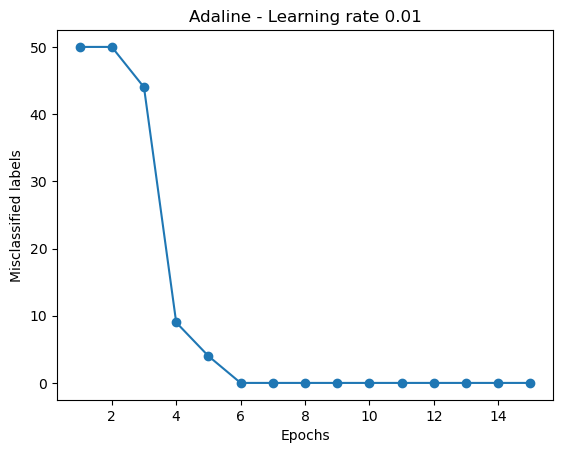

In [13]:
plt.plot(range(1, len(ada.missed_) + 1), ada.missed_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Misclassified labels')
plt.title(f'Adaline - Learning rate {eta}')
plt.show()

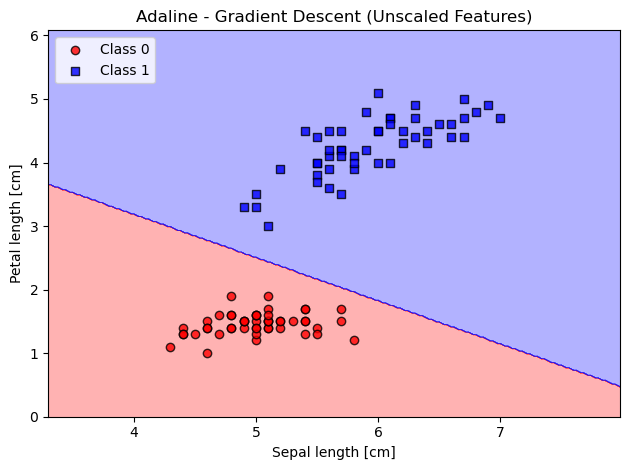

In [14]:
plot_decision_regions(X, y, classifier=ada)
plt.title('Adaline - Gradient Descent (Unscaled Features)')
plt.xlabel('Sepal length [cm]')
plt.ylabel('Petal length [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Changing the learning rate

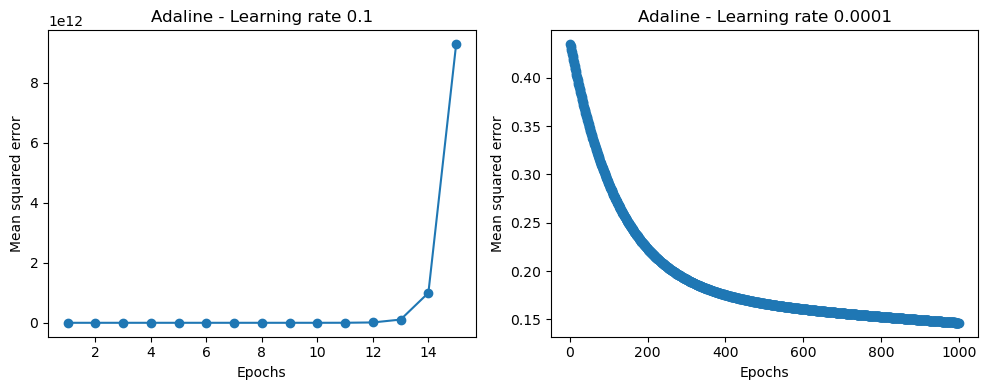

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ada1 = AdalineGD(n_iter=15, eta=0.1).fit(X, y)
ax[0].plot(range(1, len(ada1.losses_) + 1), ada1.losses_, marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Mean squared error')
ax[0].set_title('Adaline - Learning rate 0.1')

ada2 = AdalineGD(n_iter=1000, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.losses_) + 1), ada2.losses_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
ax[1].set_title('Adaline - Learning rate 0.0001')

plt.tight_layout()
plt.show()

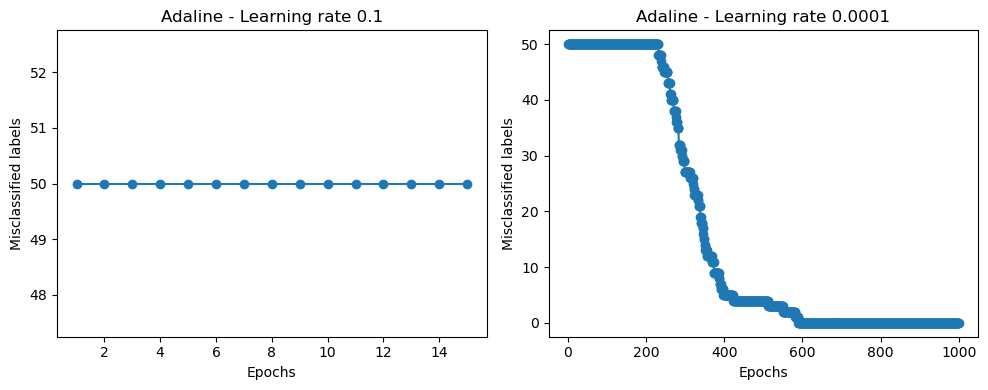

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].plot(range(1, len(ada1.missed_) + 1), ada1.missed_, marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Misclassified labels')
ax[0].set_title('Adaline - Learning rate 0.1')

ax[1].plot(range(1, len(ada2.missed_) + 1), ada2.missed_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Misclassified labels')
ax[1].set_title('Adaline - Learning rate 0.0001')

plt.tight_layout()
plt.show()

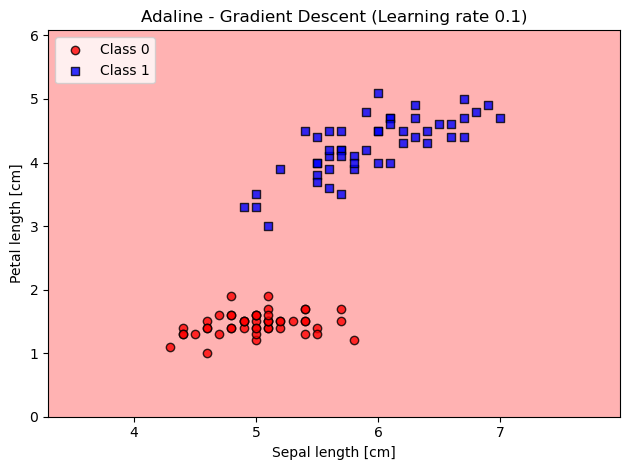

In [17]:
plot_decision_regions(X, y, classifier=ada1)
plt.title('Adaline - Gradient Descent (Learning rate 0.1)')
plt.xlabel('Sepal length [cm]')
plt.ylabel('Petal length [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Improving gradient descent through feature scaling

When features have very different scales (e.g., sepal length in centimeters vs. smaller or larger ranges), gradient descent can take a long time to converge. **Standardization** often helps the algorithm to converge faster by scaling all features to a mean of 0 and standard deviation of 1.

### Standardizing the features

We compute the standardized value for a feature $x$ as:
$$x_{\text{std}} = \frac{x - \mu}{\sigma}$$

where $\mu$ is the mean of the feature, and $\sigma$ is the standard deviation.

In [18]:
# Standardize features
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

X_std[:5]

array([[-0.5810659 , -1.01435952],
       [-0.89430898, -1.01435952],
       [-1.20755205, -1.08374115],
       [-1.36417359, -0.94497788],
       [-0.73768744, -1.01435952]])

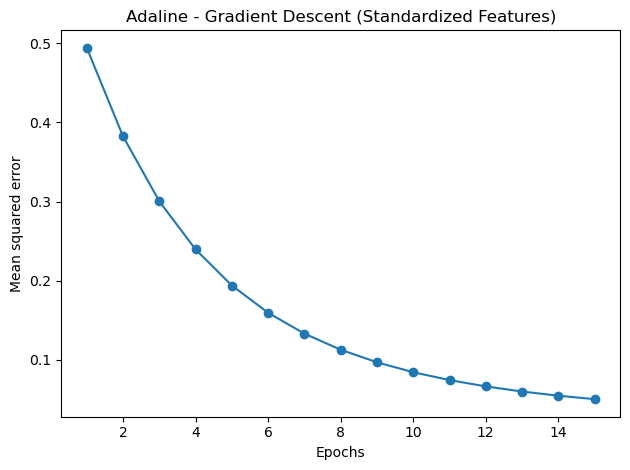

In [19]:
ada_gd = AdalineGD(n_iter=15, eta=0.1)
ada_gd.fit(X_std, y)

plt.figure()
plt.plot(range(1, len(ada_gd.losses_) + 1), ada_gd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.title('Adaline - Gradient Descent (Standardized Features)')
plt.tight_layout()
plt.show()

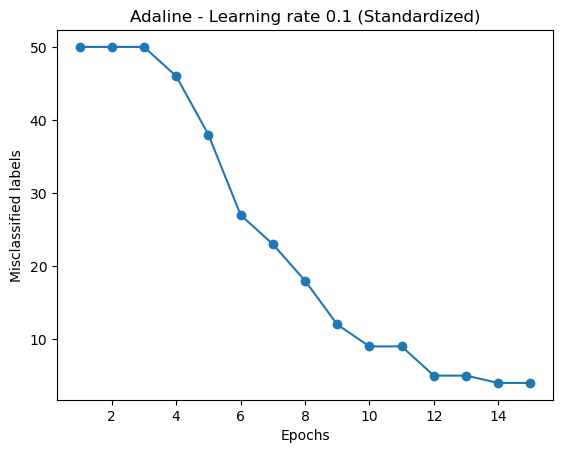

In [20]:
plt.plot(range(1, len(ada_gd.missed_) + 1), ada_gd.missed_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Misclassified labels')
plt.title('Adaline - Learning rate 0.1 (Standardized)')
plt.show()

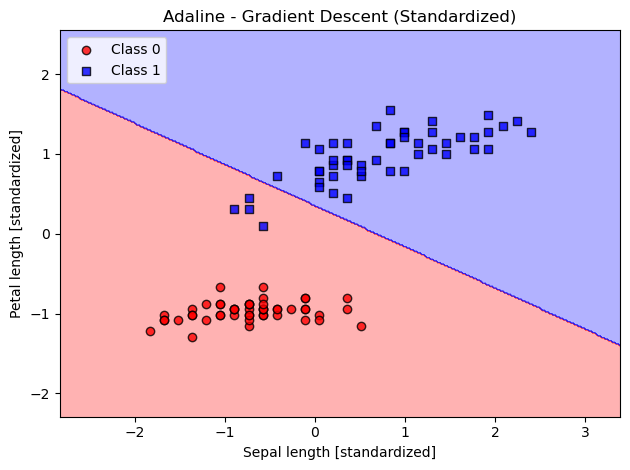

In [21]:
plt.figure()
plot_decision_regions(X_std, y, classifier=ada_gd)
plt.title('Adaline - Gradient Descent (Standardized)')
plt.xlabel('Sepal length [standardized]')
plt.ylabel('Petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

With standardized features, the algorithm converges much more smoothly and typically achieves better performance when the learning rate is chosen appropriately.

---
## Conclusions
- Adaline uses a linear activation function and MSE loss.
- Feature standardization can drastically improve convergence speed.
- The learning rate ($\eta$) must be chosen carefully. A rate too large can cause divergence, while a very small rate might slow down convergence.

Next steps could include trying different feature subsets, adding regularization, or experimenting with alternative optimization techniques (like stochastic gradient descent).